In [342]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sns
from collections import defaultdict
import os

In [343]:
file_paths_list = []
parent = None
if 'lunar_analog_spectra' not in os.listdir(os.getcwd()):
    print(f'lunar_analog_spectra folder not found')
else:
    parent = os.path.join(os.getcwd(), 'lunar_analog_spectra')
    for folder_name in os.listdir(parent):
        if folder_name[-9:] == ".DS_Store": continue
        folder_path = os.path.join(parent, folder_name)
        for file in os.listdir(folder_path):
            if file[-4:] == '.csv':
                file_path = os.path.join(folder_path, file)
                file_paths_list.append(file_path)

print(f"# of file paths: {len(file_paths_list)}")

# of file paths: 26


In [344]:
# assumed step size between m3 points 
# 10nm -> 0.01 microns = micrometers
STEPSIZE = 0.01

# boundaries for wavelengths, outside of which to ignore/truncate data
# re-determined with boundaries of m3 data
WL_MIN = 0.446
WL_MAX = 2.99

# TODO (in order of priority)
# !save binned xy pairs and cubic spline xy pairs to CSVs
# convert to python script file to run from cli
# modify to read in a folder of csvs and a target to bin to (m3 in original case)
# use variable (0.02 vs 0.04) step size based on micron range
# rename + recolor graph legend
# save graphs into subfolders based on lunar_analog_spectra folders (Iceland_JB501C graph goes into /Glass_volcanics)
# prompt user whether to save graphs

# step size until 1.57 microns
# STEPSIZE_PRE = 0.02
# step size after 1.57 microns 
# STEPSIZE_POST = 0.04

In [345]:
# boundaries: 
# m^3
# 0.46 microns - 460 nanometers
# 3 microns  - 3000 nanometers
# trailblazer
# 0.6 microns - 600 nanometers
# 3.6 microns - 3600 nanometers

# bin methods
# 1:1, cubic spline over 84 points (check for uniform step size)

In [346]:
# m3 = pd.read_csv('m3 original data.csv')
m3_path = 'clark_m3_lab_spectra/Clark et al M3_Wavelengths_center channel or mean of Gaussian.txt'
# m3_path = 'Clark M3 targeted channels.csv'
lab_path = 'lunar_analog_spectra/Pyroxene lab spectra FDL/USGS pigeonite HS199.csv'

# 20250202: using clark files as wavelength bin centers
m3 = pd.read_csv(m3_path, skiprows=3)
# m3 = pd.read_csv(m3_path, skiprows=0)
print(m3.head())
lab = pd.read_csv(lab_path)
print(lab.head())


   M3 Wavelengths (µm)
0              0.44602
1              0.45600
2              0.46598
3              0.47596
4              0.48595
   Wavelength (nm)  Pigeonite hs199 spliced
0            301.1                 0.066997
1            305.1                 0.071523
2            309.1                 0.077046
3            313.1                 0.079934
4            317.1                 0.087208


In [347]:
# for clark file
m3.columns = ['Wavelength (µm)'] 

x_m3 = (m3['Wavelength (µm)']).tolist()
x_m3 = [f"{wl:.5f}" for wl in x_m3]
print(f"# of m^3 wavelengths: {len(x_m3)}, first and last 10: \n{x_m3[0:10]}, \n{x_m3[-1-10:-1]}")

WL_MIN = float(x_m3[0])-STEPSIZE/2
WL_MAX = float(x_m3[-1])+STEPSIZE/2
print(f"Updated WL_MIN={WL_MIN} and WL_MAX={WL_MAX}")

# of m^3 wavelengths: 256, first and last 10: 
['0.44602', '0.45600', '0.46598', '0.47596', '0.48595', '0.49593', '0.50591', '0.51589', '0.52587', '0.53585'], 
['2.89136', '2.90134', '2.91132', '2.92130', '2.93128', '2.94126', '2.95125', '2.96123', '2.97121', '2.98119']
Updated WL_MIN=0.44102 and WL_MAX=2.9961699999999998


In [348]:
lab['Wavelength (µm)'] = lab['Wavelength (nm)']/1000
lab = lab.set_index('Wavelength (µm)')
lab.columns = lab.columns.str.replace(",","")
print(f'lab df: \n{lab.head()}\n')

y_column_label = lab.columns[1]
x_raw = list(lab.index)
# x_raw rounding to 5 digits and recast to float (optional)
x_raw = [float(f"{wl:.5f}") for wl in x_raw]
y_raw = list(lab[y_column_label])

print(f"5 [x],[y] raw pairs: \nfirst\n{x_raw[0:5]}, \n{y_raw[0:5]} \nlast\n{x_raw[-1-5:-1]}, \n{y_raw[-1-5:-1]}")

lab df: 
                 Wavelength (nm)  Pigeonite hs199 spliced
Wavelength (µm)                                          
0.3011                     301.1                 0.066997
0.3051                     305.1                 0.071523
0.3091                     309.1                 0.077046
0.3131                     313.1                 0.079934
0.3171                     317.1                 0.087208

5 [x],[y] raw pairs: 
first
[0.3011, 0.3051, 0.3091, 0.3131, 0.3171], 
[0.066997, 0.071523, 0.077046, 0.079934, 0.087208] 
last
[3.98169, 3.98474, 3.98781, 3.99088, 3.99396], 
[0.203316, 0.203203, 0.20309, 0.203034, 0.203034]


In [349]:
# initialize bins stored as numerical strings
binned_raw = defaultdict(list)
for x in x_m3:
    binned_raw[x] = []
len(binned_raw)

256

In [350]:
# append points to bin with wavelength within half of stepsize
# average points across list
# precondition: wavelengths are sorted in ascending order

binCounter = 0
for x,y in zip(x_raw, y_raw):
    if x < WL_MIN or x > WL_MAX: continue

    lbound = float(x_m3[binCounter]) - STEPSIZE/2
    rbound = float(x_m3[binCounter]) + STEPSIZE/2

    # while point doesn't fit into current bin
    # increment binCounter unless not found
    while x > rbound: 
        if binCounter + 1 < len(x_m3):
            binCounter += 1

            # update bin bounds
            lbound = float(x_m3[binCounter]) - STEPSIZE/2
            rbound = float(x_m3[binCounter]) + STEPSIZE/2
        else:
            print(f"Point {x, y} within WL MINMAX range {WL_MIN, WL_MAX} but no bin found, last {lbound, rbound}")
            break
    
    # add point to bin
    binned_raw[x_m3[binCounter]].append((x,y))
    
print(f"bin index: {binCounter}, input list size: {len(x_raw)}")

bin index: 255, input list size: 1149


In [351]:
# average all wavelength values in the same bin
x_avg = []
y_avg = []
for count, bin in enumerate(binned_raw):
    # print(bin, type(bin))
    if len(binned_raw[bin]) == 0:
        # x_avg.append(bin)
        # y_avg.append(-1)
        print(f"Empty bin at {bin}")
        continue


    # average over all raw reflectance values
    avgx = 0
    avgy = 0
    for x,y in binned_raw[bin]:
        avgx += x
        avgy += y
    avgx /= len(binned_raw[bin])
    avgy /= len(binned_raw[bin])

    y_avg.append(avgy)
    # take band center as WL coordinate to match to target 10nm
    x_avg.append(float(bin)) 
    # x_avg.append(avgx)

print(f"# of average reflectance values {len(x_avg), len(y_avg)}, first and last averaged points {[(x_avg[0], y_avg[0]), (x_avg[-1], y_avg[-1])]}")

Empty bin at 0.84526
Empty bin at 0.86522
Empty bin at 2.39231
Empty bin at 2.41227
Empty bin at 2.43223
Empty bin at 2.45220
Empty bin at 2.47216
Empty bin at 2.48214
Empty bin at 2.50210
Empty bin at 2.51208
Empty bin at 2.52206
Empty bin at 2.54203
Empty bin at 2.55201
Empty bin at 2.57197
Empty bin at 2.58195
# of average reflectance values (241, 241), first and last averaged points [(0.44602, 0.14990233333333333), (2.99117, 0.1147345)]


In [352]:
# # drop bins based on range
# # x = wl
# # y = reflectance
# x_avg_drop = x_avg
# y_avg_drop = y_avg
# for c, (xi,yi) in enumerate(zip(x_avg, y_avg)):
#     if (x )
#     if (c+1) % 2 == 0:
#         x_avg_drop.remove(xi)
#         y_avg_drop.remove(yi)


# print(f"# of average reflectance values {len(x_avg), len(y_avg)}, first and last averaged points {[(x_avg[0], y_avg[0]), (x_avg[-1], y_avg[-1])]}")

In [353]:
# troubleshoot for cubic spline failing
# because x_avg is not sorted ascending
# occurs when lab data is being skipped
# due to bad WL_MIN, WL_MAX boundaries

highest = 0
for i in range(len(x_avg)):
    try:
        if float(x_avg[i]) < highest:
            print(i, x_avg[i], "<", highest, x_avg[i-1])
    except Exception as e:
        print(e)
        print(i, x_avg[i], highest, "excepting")
    highest = float(x_avg[i])

In [354]:
from scipy.interpolate import CubicSpline

spline_points = len(x_avg)
cs_avg = CubicSpline(x_avg, y_avg)

x_spline_avg = list(np.linspace(WL_MIN, WL_MAX, spline_points))
x_spline_avg = list(np.linspace(x_avg[0], x_avg[-1], spline_points))
y_spline_avg = list(cs_avg(x_spline_avg))

# len(x_spline_avg), len(y_spline_avg)

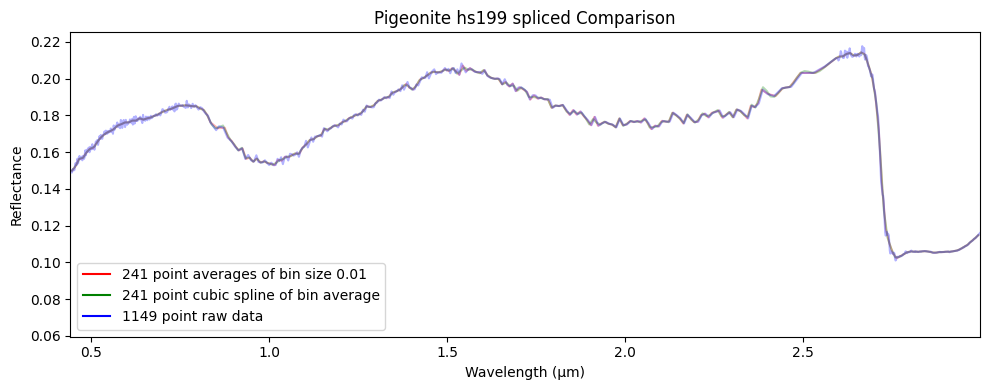

In [355]:
plot.rcParams['figure.figsize'] = (10,4)

ax = sns.lineplot(
    x = x_avg,
    y = y_avg,
    label = f"{len(x_avg)} point averages of bin size {STEPSIZE}",
    color = "red",
)

ax = sns.lineplot(
    x = x_spline_avg,
    y = y_spline_avg,
    label = f"{len(x_spline_avg)} point cubic spline of bin average",
    color = "green",
)

ax = sns.lineplot(
    x = x_raw,
    y = y_raw,
    label = f"{len(x_raw)} point raw data",
    color = 'blue',
)

for line in ax.lines:
    line.set_alpha(0.3)


plot.title(f"{y_column_label} Comparison")
plot.xlabel('Wavelength (µm)')
plot.ylabel('Reflectance')

plot.xlim(WL_MIN, WL_MAX)
plot.tight_layout()
# plot.savefig(f'graphs/{y_column_label} Comparison.png', bbox_inches='tight', dpi = 1000, transparent = False)
plot.savefig(f'graphs/test/{y_column_label} Comparison.png', bbox_inches='tight', dpi = 1000, transparent = False)
plot.show()

In [356]:
# match lengths of x_raw, x_avg, x_spline_avg 
# prevents data from getting cut off when saving
# since zip function in writeFile() terminates
# on shortest array running out
count = 0
while len(x_raw) != len(x_avg) or len(x_raw) != len(x_spline_avg):
    x_avg.append('')
    y_avg.append('')
    x_spline_avg.append('')
    y_spline_avg.append('')
    count += 1
if count > 0:
    print(f"Extended x,y avg and spline arrays {count} times to match x_raw")

Extended x,y avg and spline arrays 908 times to match x_raw


In [357]:
def writeFile(path, mode): # x = new, w = overwrite
    output = open(path, mode)
    output.write(f"Wavelength (µm) raw,{y_column_label} raw,Wavelength (µm) bin avg,{y_column_label} bin avg,Wavelength (µm) cubic spline of bin avg,{y_column_label} cubic spline of bin avg\n")

    # ends when shortest zip input runs out
    for xr, yr, xavg, yavg, xspline, yspline in zip(x_raw, y_raw, x_avg, y_avg, x_spline_avg, y_spline_avg):
        output.write(f"{xr},{yr},{xavg},{yavg},{xspline},{yspline}\n")
    output.close()

In [358]:
# output_path = file_paths_list[0].replace('/lunar_analog_spectra/', '/csv output/')
output_path = file_path.replace('/lunar_analog_spectra/', '/csv output/')

try:
    writeFile(output_path, 'x')
    print('file saved')
except FileExistsError:
    # writeFile(output_path,'w')
    print('file present')
    pass
except Exception as e:
    print(e)
    pass

file present
